BloomTech Data Science

*Unit 2, Sprint 2, Module 1*

---

# Decision Trees

- clean data with **outliers and missing values**
- use scikit-learn **pipelines**
- use scikit-learn for **decision trees**
- get and interpret **feature importances** of a tree-based model
- understand why decision trees are useful to model **non-linear, non-monotonic** relationships and **feature interactions**

### Setup

Run the code cell below. You can work locally or on Colab.

Libraries

- **category_encoders**
- **graphviz**
- ipywidgets
- matplotlib
- numpy
- pandas
- **plotly**
- seaborn
- scikit-learn
- ydata-profiling

In [ ]:
!pip install category_encoders ydata-profiling
!pip install --upgrade Pillow
;


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 352.3/352.3 kB 20.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.7/102.7 kB 11.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 679.5/679.5 kB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 24.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 455.4/455.4 kB 34.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 20.8 MB/s eta 0:00:00
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27081 sha256=b134d12af2d6d7743ca56aec5aec1e827379d292d1d395bdea058fd89423fe53
  Stored in directory: /root/.cache/pip/wheels/dd/91/29/a79cecb328d01739e64017b6fb9a1ab9d8cb1853098ec5966d
Successfully built htmlmin
  Attempt

In [ ]:
import sys
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
#from pandas_profiling  import ProfileReport
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://github.com/bloominstituteoftechnology/DS-Unit-2-Kaggle-Challenge/tree/main/data/waterpumps/'
    !pip install category_encoders==2.*
    !pip install ydata-profiling

# If you're working locally:
else:
    DATA_PATH = '../data/'

;

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


''

# Clean data with outliers and missing values 🚰

## Overview

Real-world data is often dirty. [The Quartz guide to bad data](https://github.com/Quartz/bad-data-guide) is a "reference to problems seen in real-world data along with suggestions on how to resolve them." One of the common issues is ["Zeros replace missing values."](https://github.com/Quartz/bad-data-guide#zeros-replace-missing-values)

This is true of the Tanzania Waterpumps data, which we'll use throughout your Kaggle Challenge sprint:

> Using data from Taarifa and the Tanzanian Ministry of Water, can you predict which pumps are functional, which need some repairs, and which don't work at all? Predict one of these three classes based on a number of variables about what kind of pump is operating, when it was installed, and how it is managed. A smart understanding of which waterpoints will fail can improve maintenance operations and ensure that clean, potable water is available to communities across Tanzania.


The Tanzania Waterpumps data has outliers and missing values. Let's start to clean it.

First, load & split data.

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

train = pd.merge(pd.read_csv('/content/train_features.csv'),
                 pd.read_csv('/content/train_labels.csv'))
test = pd.read_csv('/content/test_features.csv')
sample_submission = pd.read_csv('/content/new_submission.csv')

# Split train into train & val
train, val = train_test_split(train, train_size=0.80, test_size=0.20,
                              stratify=train['status_group'], random_state=42)

train.shape, val.shape, test.shape

((38016, 41), (9504, 41), (11880, 40))

This is a multi-class classification problem. The majority class occurs with 54% frequency.

In [ ]:
train['status_group'].value_counts(normalize=True)

functional                 0.542982
non functional             0.384075
functional needs repair    0.072943
Name: status_group, dtype: float64

In [ ]:
print('Baseline Accuracy:', train['status_group'].value_counts(normalize=True).max())

Baseline Accuracy: 0.5429819023569024


One common issues is ["zeros replace missing values."](https://github.com/Quartz/bad-data-guide#zeros-replace-missing-values)

We can use [ydata-profiling(FKA Pandas Profiling)](https://github.com/pandas-profiling/pandas-profiling) to get a report, with warnings about frequent zeros, and much more!

In [ ]:
from ydata_profiling import ProfileReport
profile = ProfileReport(train, minimal=True).to_notebook_iframe()

profile

Note that longitude has 3% zeros. Some of the locations are at ["Null Island"](https://en.wikipedia.org/wiki/Null_Island) instead of Tanzania.

In [ ]:
import plotly.express as px
px.scatter(train, x='longitude', y='latitude', color='status_group', opacity=0.1)

The latitude is approximately zero, but not exactly:

In [ ]:
train[['longitude', 'latitude']].describe()

,longitude,latitude
count,38016.000000,3.801600e+04
mean,34.087297,-5.701490e+00
std,6.557065,2.941479e+00
min,0.000000,-1.164944e+01
25%,33.087091,-8.520828e+00
50%,34.911409,-5.014481e+00
75%,37.179490,-3.326120e+00
max,40.345193,-2.000000e-08


## Follow Along

#### Define a function to wrangle train, validate, and test sets in the same way.

Fix the location, and do more data cleaning and feature engineering.

In [ ]:
import numpy as np

def wrangle(X):
    """Wrangle train, validate, and test sets in the same way"""

    # Prevent SettingWithCopyWarning
    X = X.copy()

    # About 3% of the time, latitude has small values near zero,
    # outside Tanzania, so we'll treat these values like zero.
    X['latitude'] = X['latitude'].replace(-2e-08, 0)

    # When columns have zeros and shouldn't, they are like null values.
    # So we will replace the zeros with nulls, and impute missing values later.
    cols_with_zeros = ['longitude', 'latitude']
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)

    # quantity & quantity_group are duplicates, so drop one
    X = X.drop(columns='quantity_group')

    # return the wrangled dataframe
    return X


train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

Now the locations look better.

In [ ]:
import plotly.express as px
px.scatter(train, x='longitude', y='latitude', color='status_group', opacity=0.1)

By the way, you can also make maps with Plotly Express. For example:

In [ ]:
# https://plot.ly/python/mapbox-layers/#base-maps-in-layoutmapboxstyle
fig = px.scatter_mapbox(train, lat='latitude', lon='longitude', color='status_group', opacity=0.1)
fig.update_layout(mapbox_style='stamen-terrain')
fig.show()

#### Select features

In [ ]:
# The status_group column is the target
target = 'status_group'

# Get a dataframe with all train columns except the target & id
train_features = train.drop(columns=[target, 'id'])

# Get a list of the numeric features
numeric_features = train_features.select_dtypes(include='number').columns.tolist()

# Get a series with the cardinality of the nonnumeric features
cardinality = train_features.select_dtypes(exclude='number').nunique()

# Get a list of all categorical features with cardinality <= 50
categorical_features = cardinality[cardinality <= 50].index.tolist()

# Combine the lists
features = numeric_features + categorical_features
print(features)

['amount_tsh', 'gps_height', 'longitude', 'latitude', 'num_private', 'region_code', 'district_code', 'population', 'construction_year', 'basin', 'region', 'public_meeting', 'recorded_by', 'scheme_management', 'permit', 'extraction_type', 'extraction_type_group', 'extraction_type_class', 'management', 'management_group', 'payment', 'payment_type', 'water_quality', 'quality_group', 'quantity', 'source', 'source_type', 'source_class', 'waterpoint_type', 'waterpoint_type_group']


In [ ]:
# Arrange data into X features matrix and y target vector
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]

## Challenge

For your Kaggle Challenge, define a function to wrangle train, validate, and test sets in the same way. Clean outliers and engineer features.

(For example, what other columns have zeros and shouldn't? What other columns are duplicates, or nearly duplicates? Can you extract the year from date_recorded? Can you engineer new features, such as the number of years from waterpump construction to waterpump inspection?)

# Use scikit-learn pipelines

## Overview

We can combine steps with pipelines: Encode, Impute, Scale, Fit, Predict!

[The Scikit-Learn User Guide explains why pipelines are useful](https://scikit-learn.org/stable/modules/compose.html), and demonstrates how to use them.

> Pipeline can be used to chain multiple estimators into one. This is useful as there is often a fixed sequence of steps in processing the data, for example feature selection, normalization and classification. Pipeline serves multiple purposes here:
> - **Convenience and encapsulation.** You only have to call fit and predict once on your data to fit a whole sequence of estimators.
> - **Joint parameter selection.** You can grid search over parameters of all estimators in the pipeline at once.
> - **Safety.** Pipelines help avoid leaking statistics from your test data into the trained model in cross-validation, by ensuring that the same samples are used to train the transformers and predictors.

#### Just for comparison's sake, here's preprocessing + Logistic Regression _without_ using a pipeline

Here's the documentation for each step in the process:

- https://contrib.scikit-learn.org/category_encoders/onehot.html
- https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html
- https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
- https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

In [ ]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

encoder = ce.OneHotEncoder(use_cat_names=True)
imputer = SimpleImputer()
scaler = StandardScaler()
model = LogisticRegression(max_iter=1000)

X_train_encoded = encoder.fit_transform(X_train)
X_train_imputed = imputer.fit_transform(X_train_encoded)
X_train_scaled = scaler.fit_transform(X_train_imputed)
model.fit(X_train_scaled, y_train)

X_val_encoded = encoder.transform(X_val)
X_val_imputed = imputer.transform(X_val_encoded)
X_val_scaled = scaler.transform(X_val_imputed)
print('Validation Accuracy', model.score(X_val_scaled, y_val))

X_test_encoded = encoder.transform(X_test)
X_test_imputed = imputer.transform(X_test_encoded)
X_test_scaled = scaler.transform(X_test_imputed)
y_pred = model.predict(X_test_scaled)

Validation Accuracy 0.7330597643097643


## Follow Along

#### Pipelines can help you write more concise code with fewer errors!

Let's rewrite the code cell above, but with a pipeline.

https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.make_pipeline.html

In [ ]:
# TODO
pipeline = make_pipeline(
    OneHotEncoder(use_cat_names = True),
    SimpleImputer(),
    StandardScaler(),
    LogisticRegression(max_iter = 1000)
)
pipeline.fit(X_train,y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['basin', 'region', 'public_meeting',
                                     'recorded_by', 'scheme_management',
                                     'permit', 'extraction_type',
                                     'extraction_type_group',
                                     'extraction_type_class', 'management',
                                     'management_group', 'payment',
                                     'payment_type', 'water_quality',
                                     'quality_group', 'quantity', 'source',
                                     'source_type', 'source_class',
                                     'waterpoint_type',
                                     'waterpoint_type_group'],
                               use_cat_names=True)),
                ('simpleimputer', SimpleImputer()),
                ('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression(max_iter=1000))])

#### Get and plot coefficients

This is slightly harder when using pipelines.

The pipeline doesn't have a `.coef_` attribute. But the model inside the pipeline does.

So, here's [how to access steps inside a pipeline](https://scikit-learn.org/stable/modules/compose.html#accessing-steps):

> Pipeline’s `named_steps` attribute allows accessing steps by name

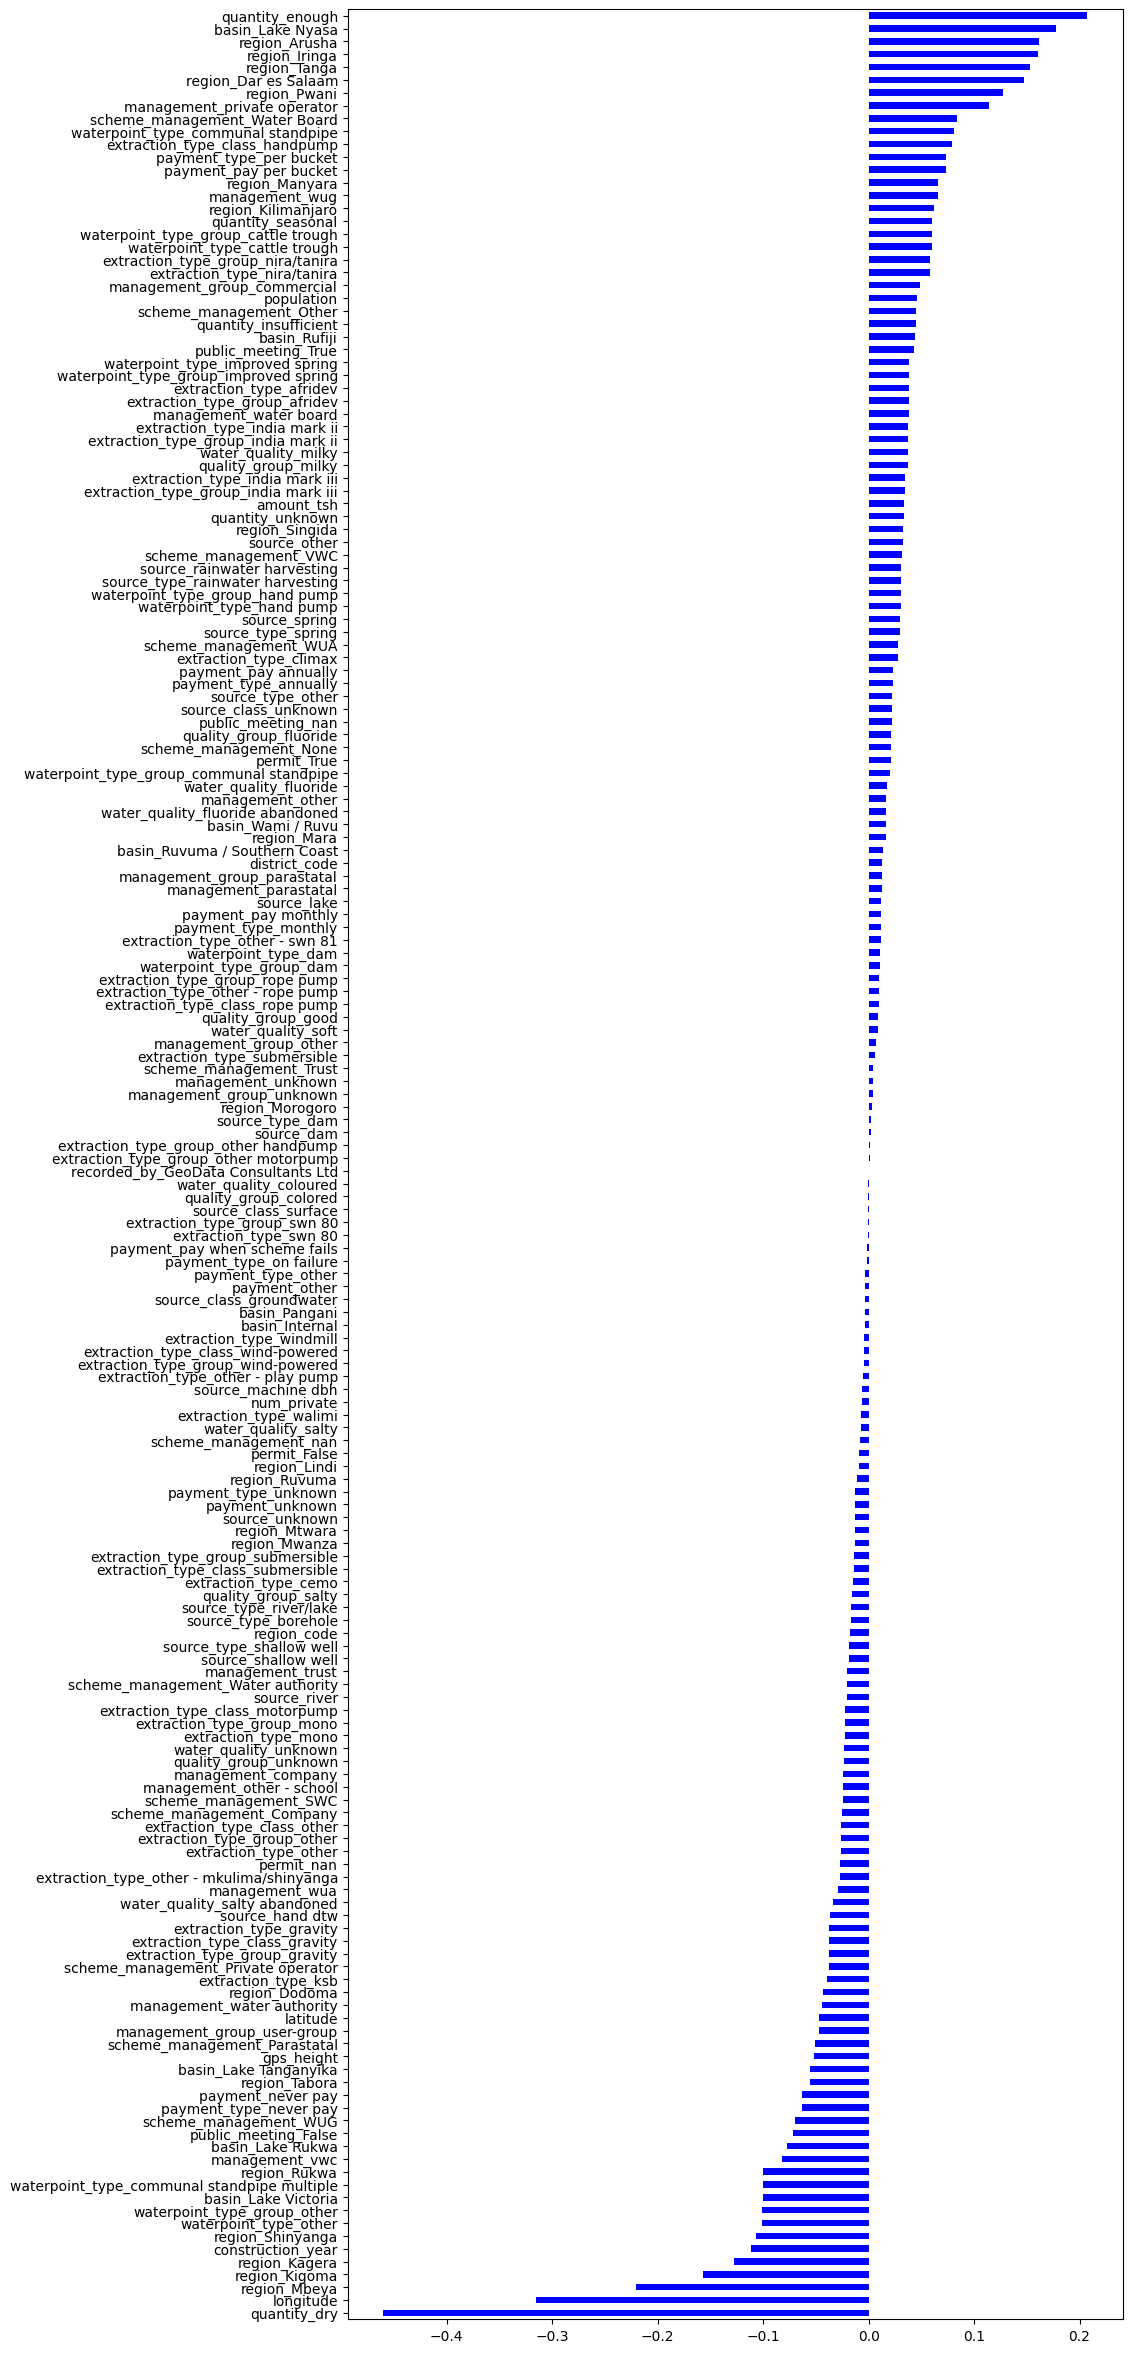

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

model = pipeline.named_steps['logisticregression']
encoder = pipeline.named_steps['onehotencoder']
encoded_columns = encoder.transform(X_val).columns
coefficients = pd.Series(model.coef_[0], encoded_columns)
plt.figure(figsize=(10,30))
coefficients.sort_values().plot.barh(color='blue');

## Challenge

For your assignment, try to use a scikit-learn pipeline. Do you consider it more convenient?

# Use scikit-learn for decision trees

## Overview

In this Unit, we learn about two "families" or types of models: Linear Models, and Trees.

We'll start today with using [Decision Trees](http://www.r2d3.us/visual-intro-to-machine-learning-part-1/), then understanding how they work. (See the Sources heading at the bottom of the notebook for lots of great links!)

Later, we'll learn about Random Forests, and Gradient Boosted Trees, which are "ensemble" models made of many trees. In practice, these "Tree Ensembles" are used more often than a single Decision Tree.

But we start with a single Tree because it's a helpful prerequisite for understanding Tree Ensembles. Also, a single, shallow decision tree is a useful baseline.

## Follow Along

https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

We will start with default parameters, including:
- `max_depth=None`
- `min_samples_leaf=1`

In [ ]:
# TODO
pipeline = make_pipeline(
    OneHotEncoder(use_cat_names = True),
    SimpleImputer(),
    DecisionTreeClassifier(min_samples_leaf = 1, max_depth = None)
)
pipeline.fit(X_train,y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['basin', 'region', 'public_meeting',
                                     'recorded_by', 'scheme_management',
                                     'permit', 'extraction_type',
                                     'extraction_type_group',
                                     'extraction_type_class', 'management',
                                     'management_group', 'payment',
                                     'payment_type', 'water_quality',
                                     'quality_group', 'quantity', 'source',
                                     'source_type', 'source_class',
                                     'waterpoint_type',
                                     'waterpoint_type_group'],
                               use_cat_names=True)),
                ('simpleimputer', SimpleImputer()),
                ('decisiontreeclassifier', DecisionTreeClassifier())])

### Plot the decision tree

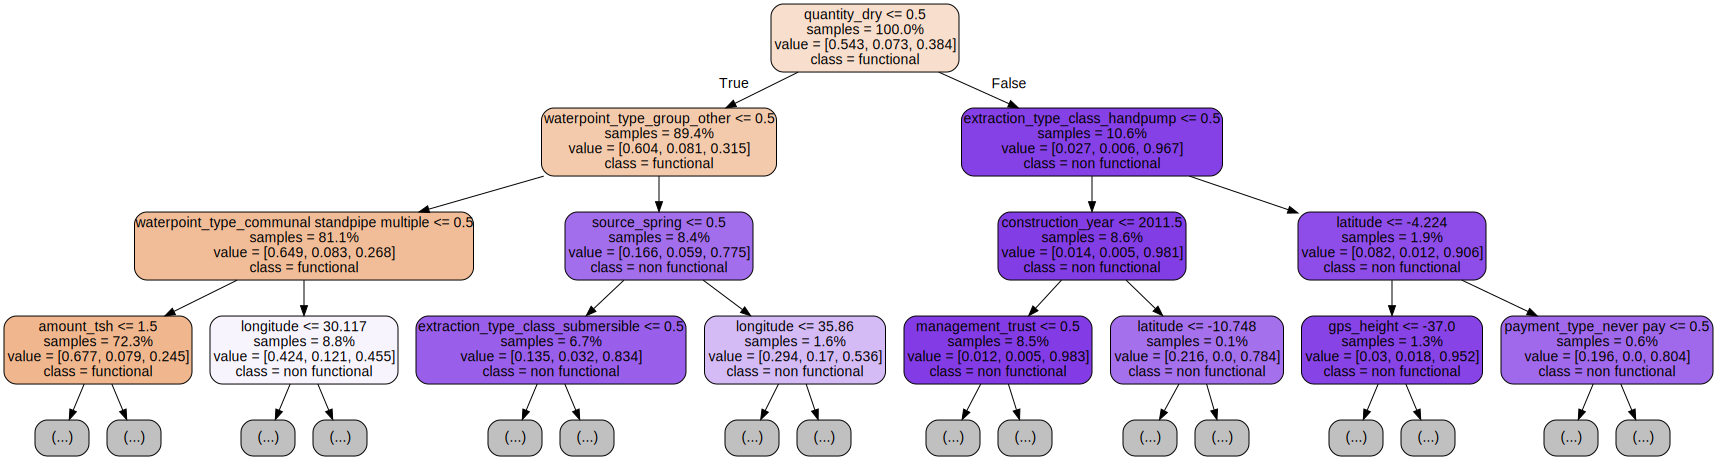

In [ ]:
# Plot tree
# https://scikit-learn.org/stable/modules/generated/sklearn.tree.export_graphviz.html
import graphviz
from sklearn.tree import export_graphviz

model = pipeline.named_steps['decisiontreeclassifier']
encoder = pipeline.named_steps['onehotencoder']
encoded_columns = encoder.transform(X_val).columns

dot_data = export_graphviz(model,
                           out_file=None,
                           max_depth=3,
                           feature_names=encoded_columns,
                           class_names=model.classes_,
                           impurity=False,
                           filled=True,
                           proportion=True,
                           rounded=True)
display(graphviz.Source(dot_data))

### Reduce complexity of the decision tree

We can use the `min_samples_leaf` parameter to reduce model complexity.

It's explained in [scikit-learn docs](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html).

Also in [A Visual Introduction to Machine Learning, Part 2](http://www.r2d3.us/visual-intro-to-machine-learning-part-2/):

> Models can be adjusted to change the way they fit the data. These 'settings' are called [hyper]parameters. An example of a decision-tree [hyper]parameter is the _minimum node size,_ which regulates the creation of new splits. A node will not split if the number of data points it contains is below the minimum node size.

In [ ]:
# TODO
pipeline = make_pipeline(
    OneHotEncoder(use_cat_names = True),
    SimpleImputer(),
    DecisionTreeClassifier(min_samples_leaf = 3, max_depth = None)
)
pipeline.fit(X_train,y_train)

## Challenge

Fit a Decision Tree classifier to make new submissions for your Kaggle challenge.

# Get and interpret feature importances of a tree-based model

## Overview

Linear models have coefficients, but trees don't. Instead, they have "feature importances."

Feature importances are always positive numbers, they don't have a sign. Feature importance measures how early & often a feature is used for the tree's "branching" decisions.

Like most predictive modeling tools and techniques, feature importances are useful, but have tradeoffs, make assumptions, and can be misinterpreted. We'll continue to discuss through this lesson and the unit.

## Follow Along

https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

In [ ]:
# TODO
classifier = DecisionTreeClassifier()

classifier.fit(X_train, y_train)
importances = pd.Series(classifier.feature_importances_, X.columns)

# Plot top n feature importances
n = 13
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh()

## Challenge

For your assignment, get and plot your feature importances. What features are most important in your model?

# Understand why decision trees are useful to model non-linear, non-monotonic relationships and feature interactions

## Overview

#### What does _(non)monotonic_ mean?!?!
- See Figures 1-3 in Wikipedia's article, [Monotonic function](https://en.wikipedia.org/wiki/Monotonic_function)
- See [World Population Growth, 1700-2010](https://ourworldindata.org/world-population-growth-past-future). World Population is non-linear and monotonic. Annual growth rate is non-linear and non-monotonic.
- See [Accidents per Mile Driven, by Driver Age](http://howwedrive.com/2009/02/20/whats-the-real-risk-of-older-drivers/). This is non-linear and non-monotonic.

#### What does _feature interactions_ mean?!?!
- See the explanation in [_Interpretable Machine Learning,_ Chapter 5.4.1, Feature Interaction](https://christophm.github.io/interpretable-ml-book/interaction.html#feature-interaction).
- See the exploration in this notebook, under the heading ***Example #3: Simple housing***

## Follow Along

### Example 1: Predict which waterpumps are functional, just based on location
(2 features, non-linear, feature interactions, classification)

### Compare a Logistic Regression with 2 features, longitude & latitude ...

In [ ]:
train_location = X_train[['longitude', 'latitude']].copy()
val_location = X_val[['longitude', 'latitude']].copy()

In [ ]:
# With just long & lat, a Logistic Regression can't beat the majority classifier baseline

lr = make_pipeline(
    SimpleImputer(),
    LogisticRegression(solver='lbfgs', multi_class='auto', n_jobs=-1)
)

lr.fit(train_location, y_train)
print('Logistic Regression:')
print('Train Accuracy', lr.score(train_location, y_train))
print('Validation Accuracy', lr.score(val_location, y_val))

Logistic Regression:
Train Accuracy 0.5429819023569024
Validation Accuracy 0.5429292929292929


### ... versus a Decision Tree Classifier with 2 features, longitude & latitude

https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

In [ ]:
# With the same 2 features, the Decision Tree's validation accuracy is
# almost 10 percentage points better

from sklearn.tree import DecisionTreeClassifier

dt = make_pipeline(
    SimpleImputer(),
    DecisionTreeClassifier(max_depth=16, random_state=42)
)

dt.fit(train_location, y_train)
print('Decision Tree:')
print('Train Accuracy', dt.score(train_location, y_train))
print('Validation Accuracy', dt.score(val_location, y_val))

Decision Tree:
Train Accuracy 0.8116582491582491
Validation Accuracy 0.6382575757575758


### Visualize the logistic regression predictions

In [ ]:
%matplotlib inline
import itertools
from math import floor
import matplotlib.pyplot as plt
import seaborn as sns

def pred_heatmap(model, X, features, class_index=-1, title='', num=100):
    """
    Visualize predicted probabilities, for classifier fit on 2 numeric features

    Parameters
    ----------
    model : scikit-learn classifier, already fit
    X : pandas dataframe, which was used to fit model
    features : list of strings, column names of the 2 numeric features
    class_index : integer, index of class label
    title : string, title of plot
    num : int, number of grid points for each feature
    """
    feature1, feature2 = features
    min1, max1 = X[feature1].min(), X[feature1].max()
    min2, max2 = X[feature2].min(), X[feature2].max()
    x1 = np.linspace(min1, max1, num)
    x2 = np.linspace(max2, min2, num)
    combos = list(itertools.product(x1, x2))
    y_pred_proba = model.predict_proba(combos)[:, class_index]
    pred_grid = y_pred_proba.reshape(num, num).T
    table = pd.DataFrame(pred_grid, columns=x1, index=x2)
    plot_every_n_ticks = int(floor(num/4))
    sns.heatmap(table, # vmin=0, vmax=1,
                xticklabels=plot_every_n_ticks,
                yticklabels=plot_every_n_ticks)
    plt.xlabel(feature1)
    plt.ylabel(feature2)
    plt.title(title)
    plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but SimpleImputer was fitted with feature names



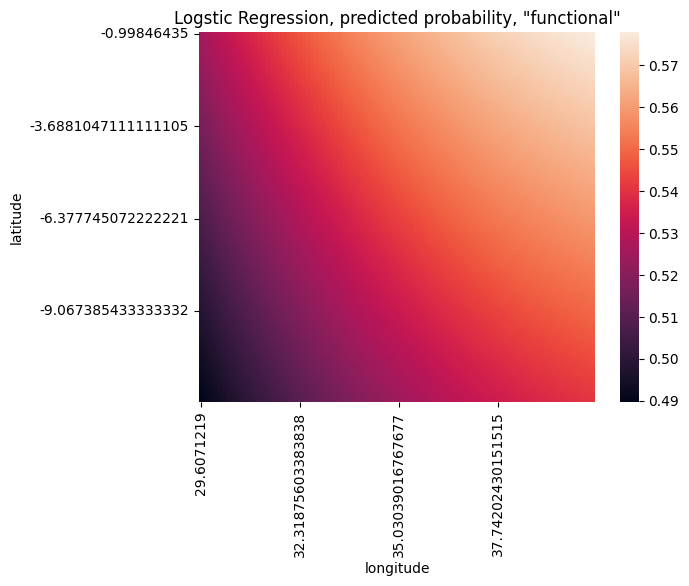

In [ ]:
pred_heatmap(lr, train_location, features=['longitude', 'latitude'],
             class_index=0, title='Logstic Regression, predicted probability, "functional"')

In [ ]:
pd.Series(lr.named_steps['logisticregression'].coef_[0],
          train_location.columns)

longitude    0.043737
latitude     0.008590
dtype: float64

### Visualize the decision tree predictions

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but SimpleImputer was fitted with feature names



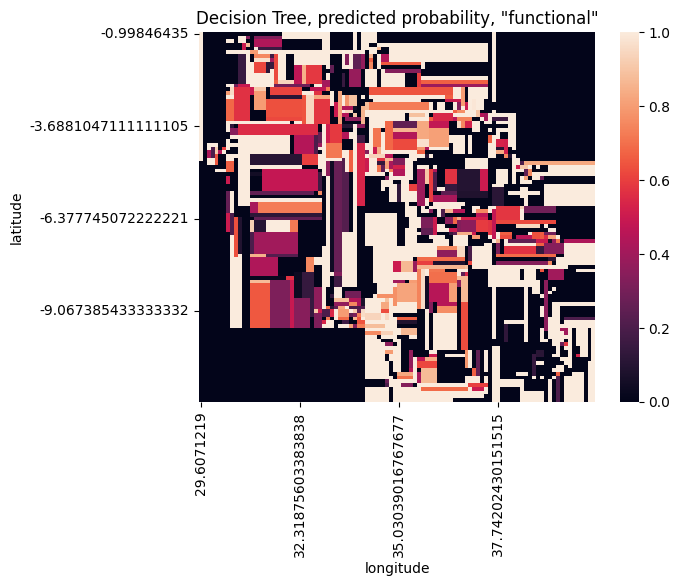

In [ ]:
pred_heatmap(dt, train_location, features=['longitude', 'latitude'],
             class_index=0, title='Decision Tree, predicted probability, "functional"')

### How does a tree grow? Branch by branch!

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but SimpleImputer was fitted with feature names



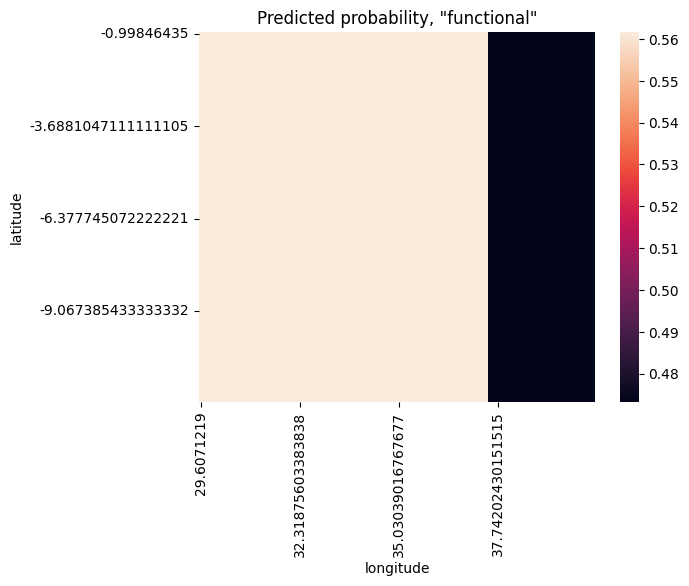

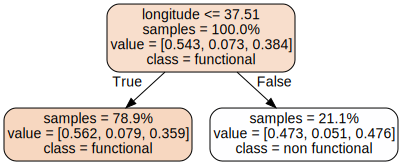

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but SimpleImputer was fitted with feature names



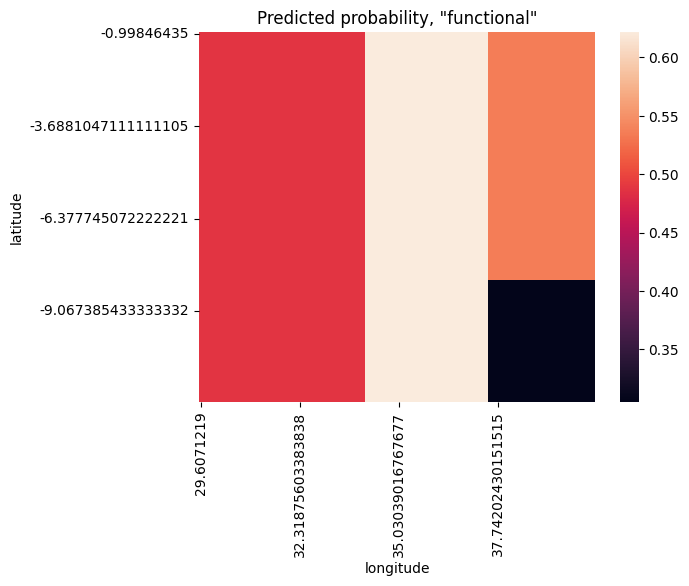

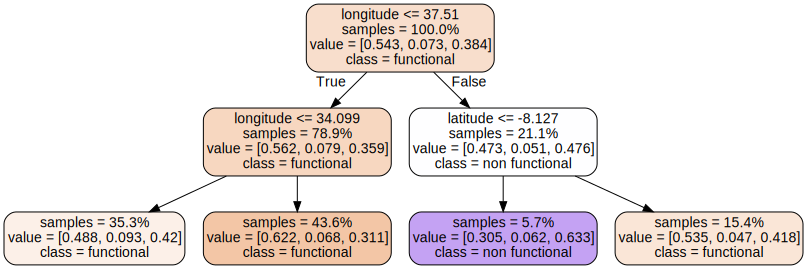

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but SimpleImputer was fitted with feature names



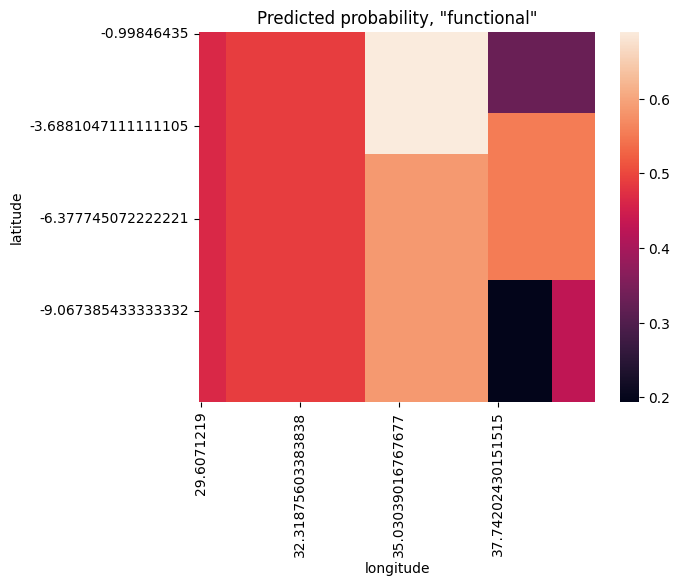

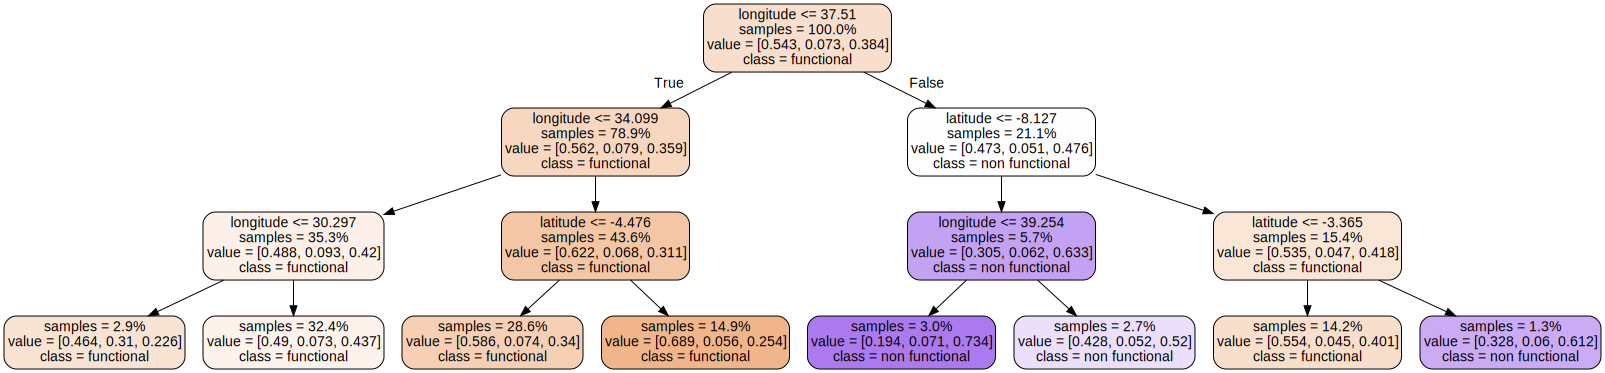

In [ ]:
from IPython.display import display, HTML
import graphviz
from sklearn.tree import export_graphviz

for max_depth in [1,2,3]:

    # Fit decision tree
    dt = make_pipeline(
        SimpleImputer(),
        DecisionTreeClassifier(max_depth=max_depth, random_state=42)
    )
    dt.fit(train_location, y_train)

    # Display depth & scores
    display(HTML(f'Max Depth {max_depth}'))
    display(HTML(f'Train Accuracy {dt.score(train_location, y_train):.2f}'))
    display(HTML(f'Validation Accuracy {dt.score(val_location, y_val):.2f}'))

    # Plot heatmap of predicted probabilities
    pred_heatmap(dt, train_location, features=['longitude', 'latitude'],
                 class_index=0, title='Predicted probability, "functional"')

    # Plot tree
    # https://scikit-learn.org/stable/modules/generated/sklearn.tree.export_graphviz.html
    dot_data = export_graphviz(dt.named_steps['decisiontreeclassifier'],
                               out_file=None,
                               max_depth=3,
                               feature_names=train_location.columns,
                               class_names=dt.classes_,
                               impurity=False,
                               filled=True,
                               proportion=True,
                               rounded=True)
    display(graphviz.Source(dot_data))

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but SimpleImputer was fitted with feature names



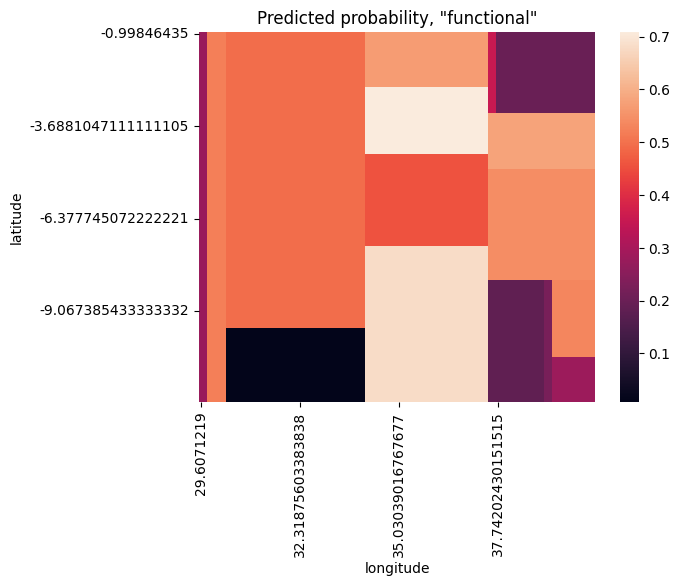

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but SimpleImputer was fitted with feature names



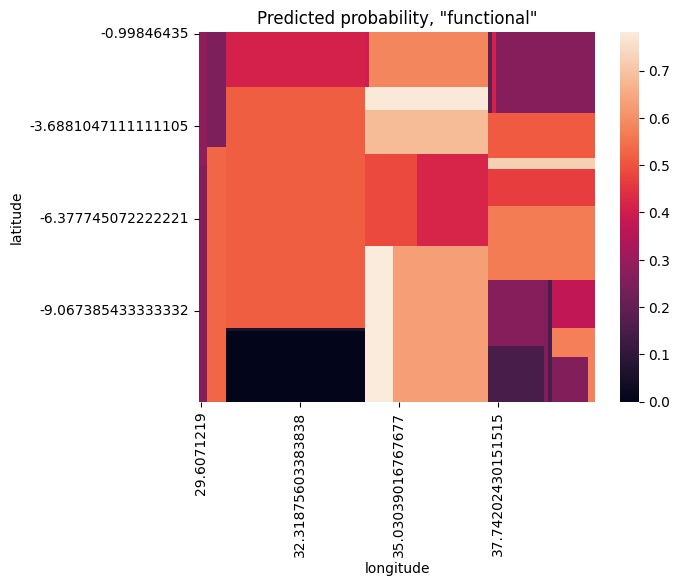

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but SimpleImputer was fitted with feature names



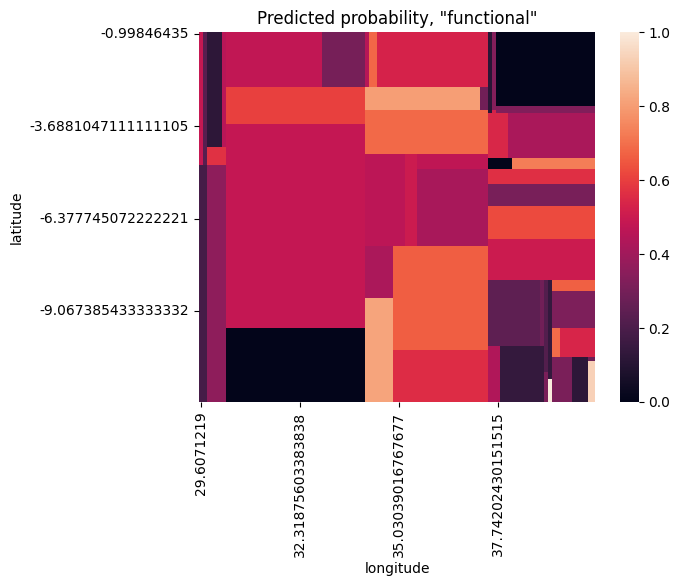

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but SimpleImputer was fitted with feature names



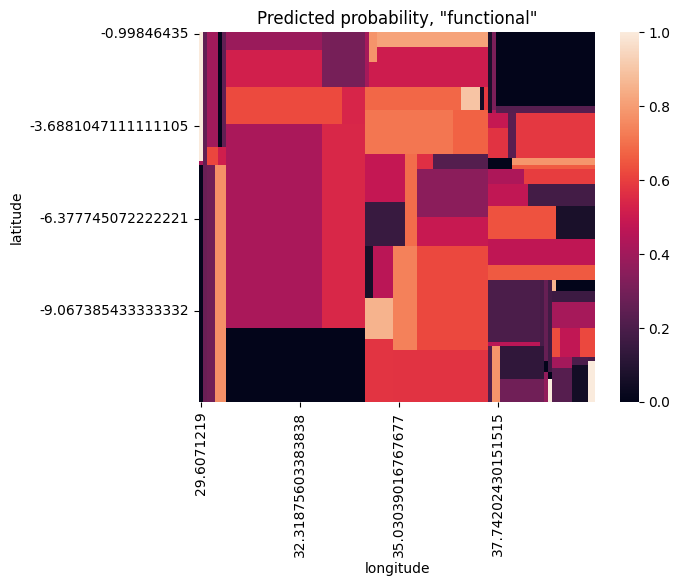

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but SimpleImputer was fitted with feature names



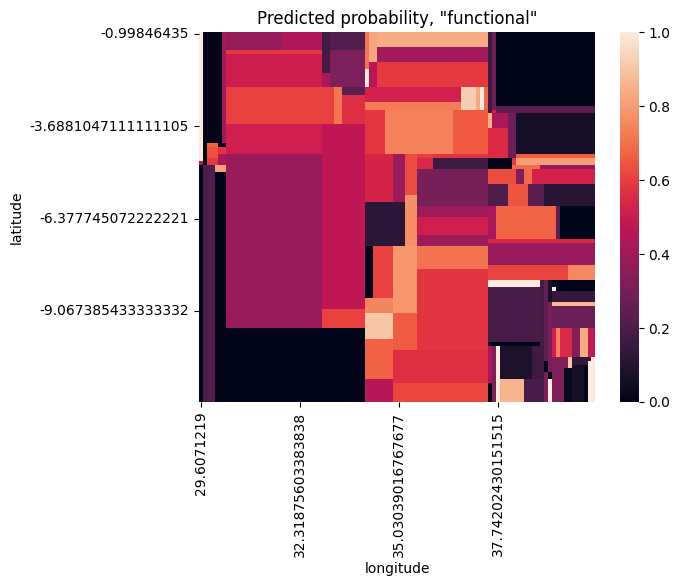

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but SimpleImputer was fitted with feature names



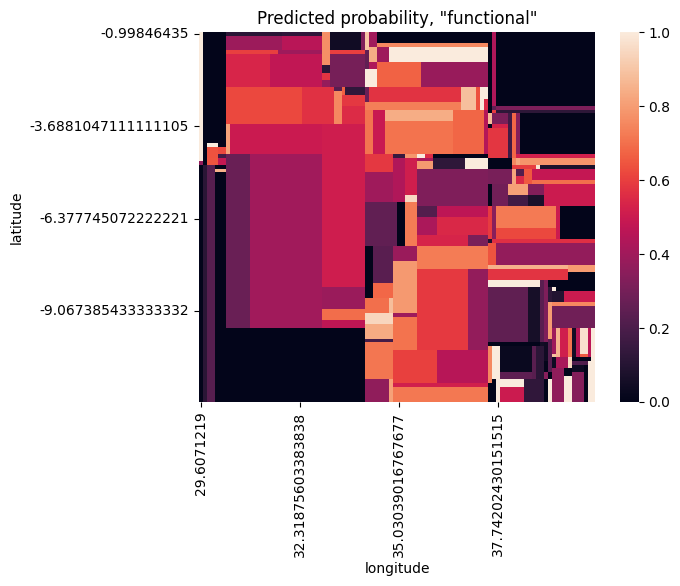

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but SimpleImputer was fitted with feature names



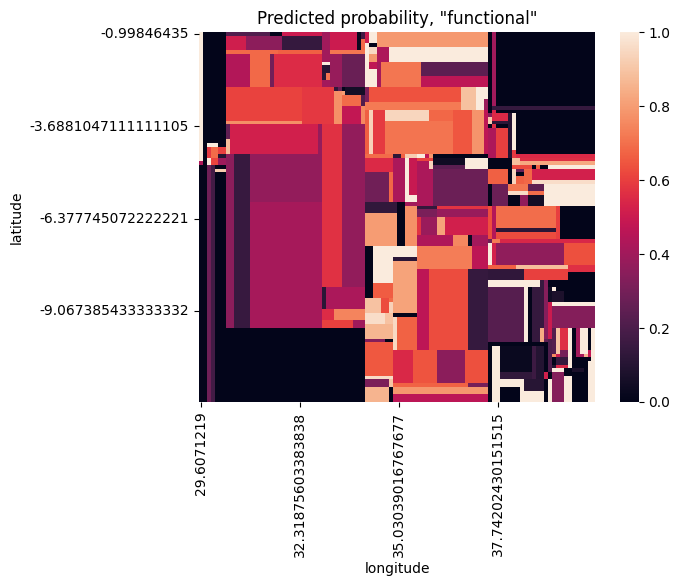

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but SimpleImputer was fitted with feature names



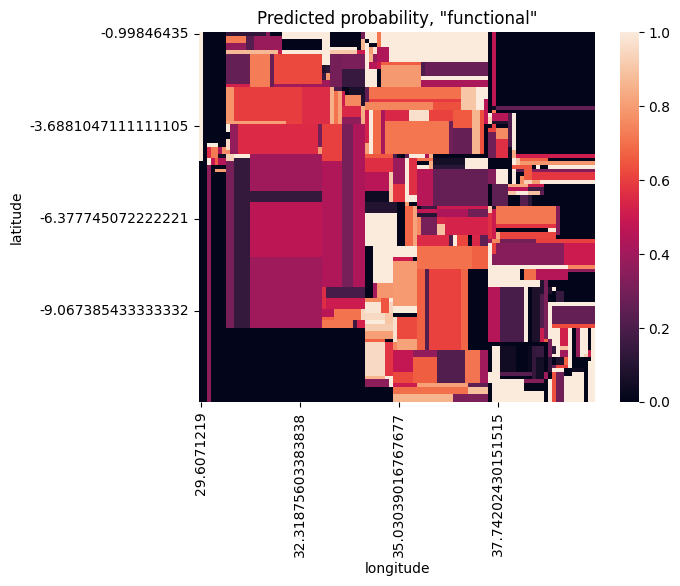

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but SimpleImputer was fitted with feature names



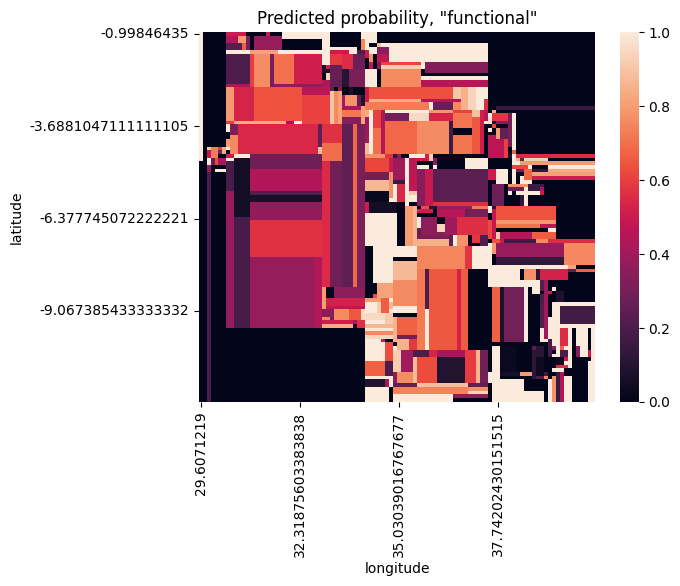

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but SimpleImputer was fitted with feature names



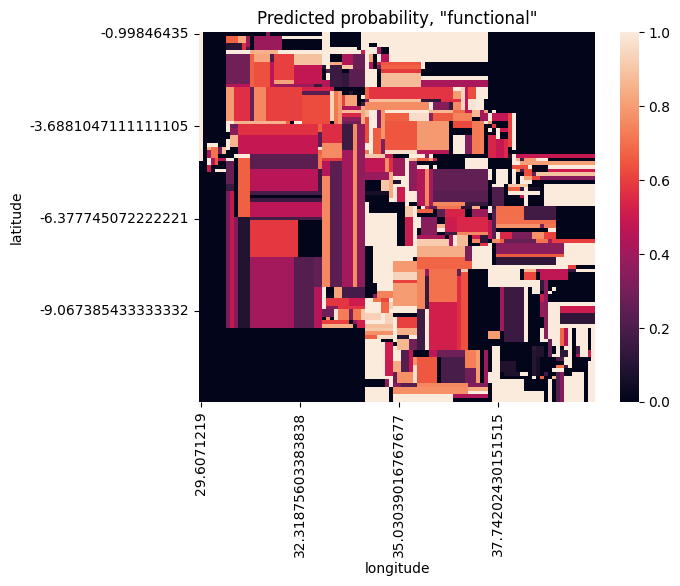

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but SimpleImputer was fitted with feature names



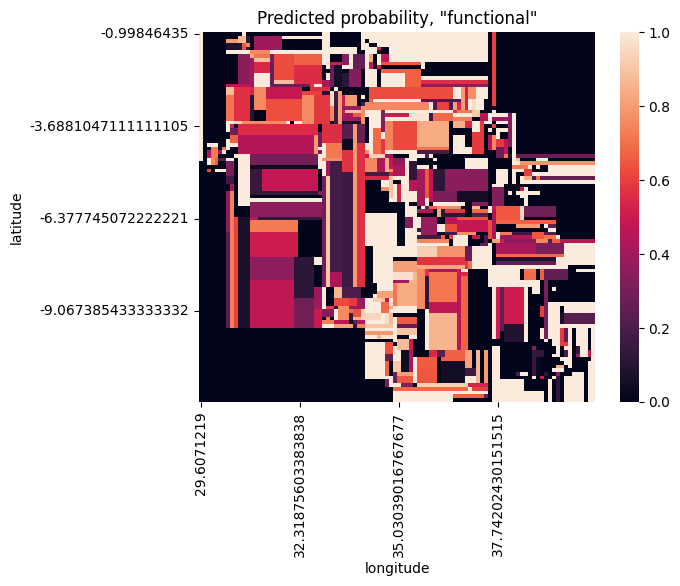

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but SimpleImputer was fitted with feature names



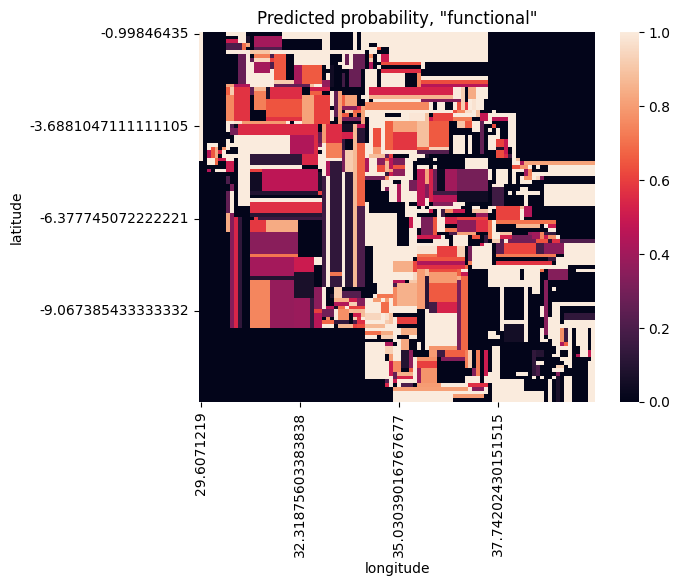

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but SimpleImputer was fitted with feature names



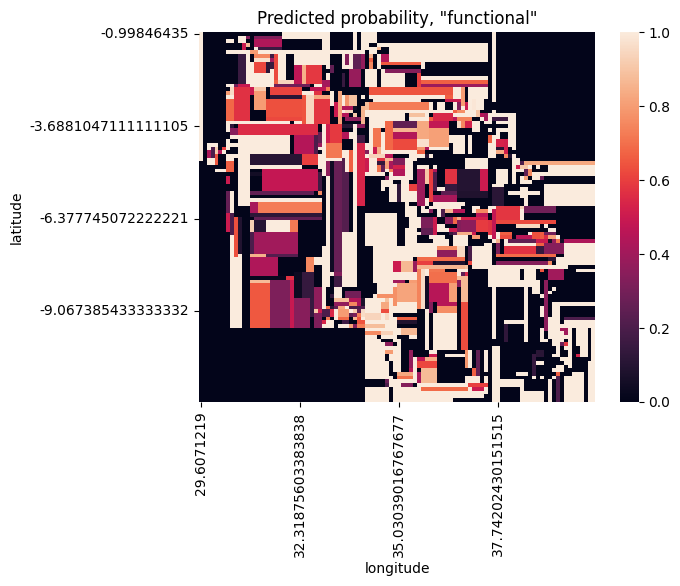

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but SimpleImputer was fitted with feature names



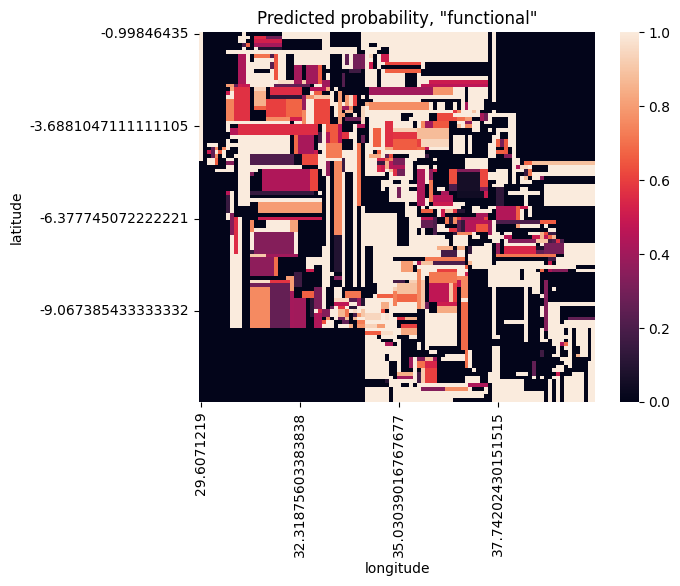

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but SimpleImputer was fitted with feature names



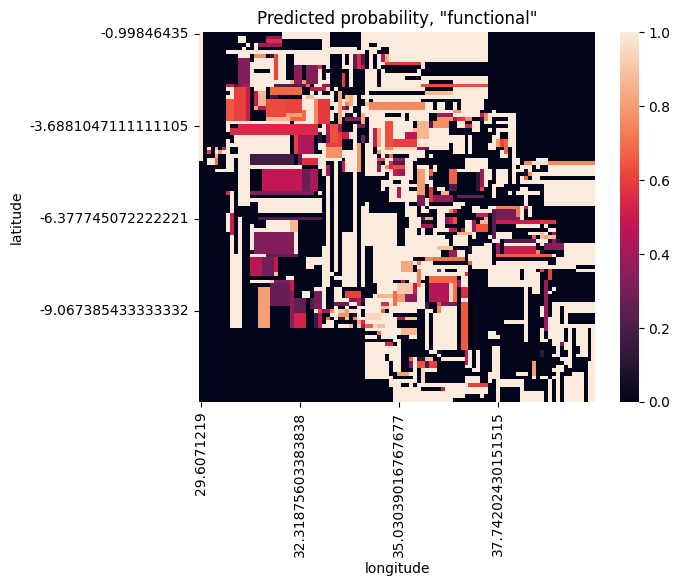

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but SimpleImputer was fitted with feature names



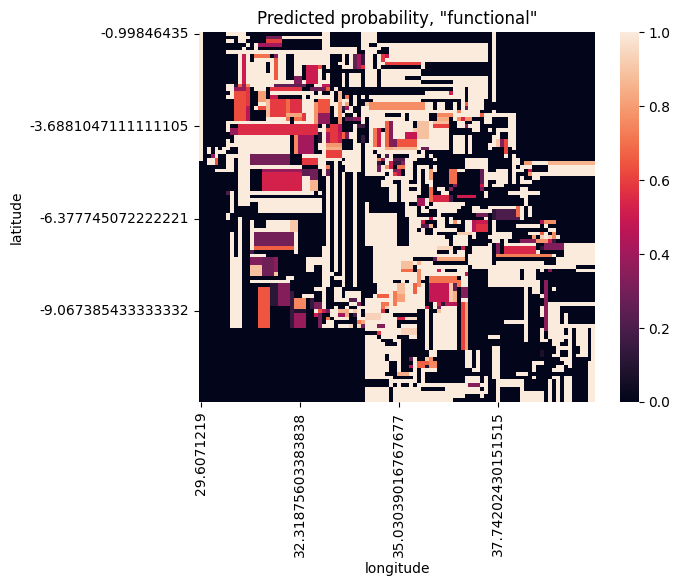

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but SimpleImputer was fitted with feature names



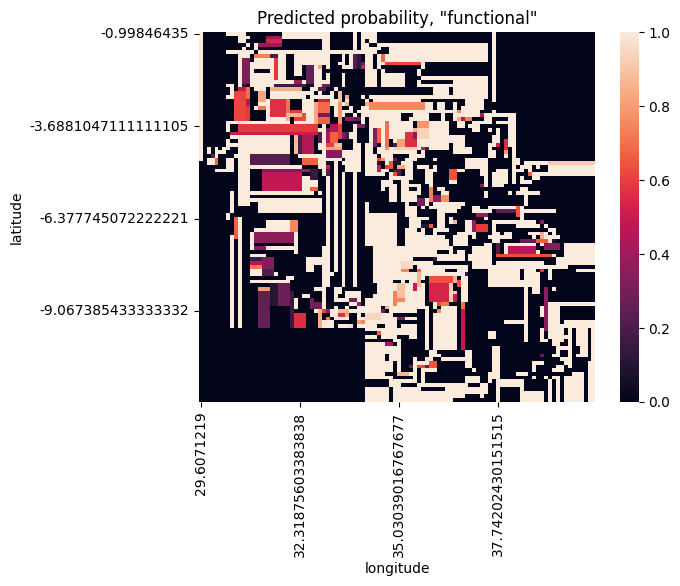

In [ ]:
for max_depth in range(4,21):

    # Fit decision tree
    dt = make_pipeline(
        SimpleImputer(),
        DecisionTreeClassifier(max_depth=max_depth, random_state=42)
    )
    dt.fit(train_location, y_train)

    # Display depth & scores
    display(HTML(f'Max Depth {max_depth}'))
    display(HTML(f'Train Accuracy {dt.score(train_location, y_train):.2f}'))
    display(HTML(f'Validation Accuracy {dt.score(val_location, y_val):.2f}'))

    # Plot heatmap of predicted probabilities
    pred_heatmap(dt, train_location, features=['longitude', 'latitude'],
                 class_index=0, title='Predicted probability, "functional"')

## Example 2: predicting golf putts
(1 feature, non-linear, regression)

https://statmodeling.stat.columbia.edu/2008/12/04/the_golf_puttin/

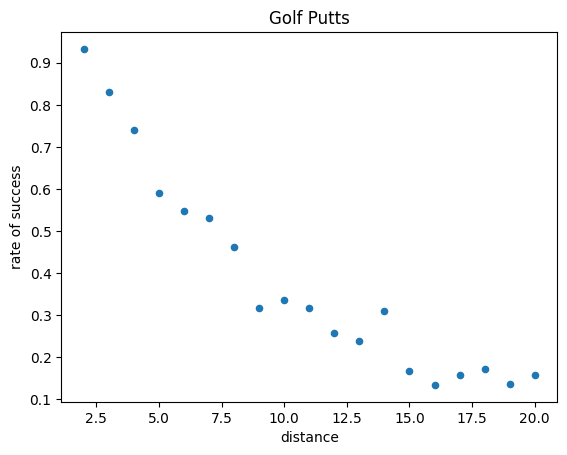

In [ ]:
columns = ['distance', 'tries', 'successes']
data = [[2, 1443, 1346],
        [3, 694, 577],
        [4, 455, 337],
        [5, 353, 208],
        [6, 272, 149],
        [7, 256, 136],
        [8, 240, 111],
        [9, 217, 69],
        [10, 200, 67],
        [11, 237, 75],
        [12, 202, 52],
        [13, 192, 46],
        [14, 174, 54],
        [15, 167, 28],
        [16, 201, 27],
        [17, 195, 31],
        [18, 191, 33],
        [19, 147, 20],
        [20, 152, 24]]

putts = pd.DataFrame(columns=columns, data=data)
putts['rate of success'] = putts['successes'] / putts['tries']
putts.plot('distance', 'rate of success', kind='scatter', title='Golf Putts');

#### Compare Linear Regression ...

R^2 Score 0.8695850610243295


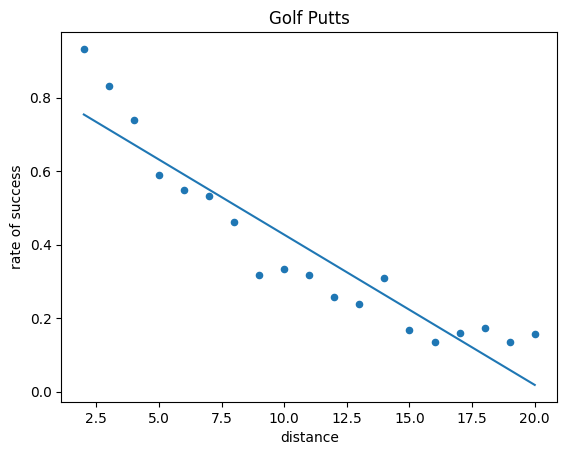

In [ ]:
from sklearn.linear_model import LinearRegression

putts_X = putts[['distance']]
putts_y = putts['rate of success']
lr = LinearRegression()
lr.fit(putts_X, putts_y)
print('R^2 Score', lr.score(putts_X, putts_y))
ax = putts.plot('distance', 'rate of success', kind='scatter', title='Golf Putts')
ax.plot(putts_X, lr.predict(putts_X));

#### ... versus a Decision Tree Regressor
https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html

In [ ]:
import graphviz
from ipywidgets import interact
from sklearn.tree import DecisionTreeRegressor, export_graphviz

def viztree(decision_tree, feature_names):
    dot_data = export_graphviz(decision_tree, out_file=None, feature_names=feature_names,
                               filled=True, rounded=True)
    return graphviz.Source(dot_data)

def putts_tree(max_depth=1):
    tree = DecisionTreeRegressor(max_depth=max_depth)
    tree.fit(putts_X, putts_y)
    print('R^2 Score', tree.score(putts_X, putts_y))
    ax = putts.plot('distance', 'rate of success', kind='scatter', title='Golf Putts')
    ax.step(putts_X, tree.predict(putts_X), where='mid')
    plt.show()
    display(viztree(tree, feature_names=['distance']))

interact(putts_tree, max_depth=(1,6,1));

interactive(children=(IntSlider(value=1, description='max_depth', max=6, min=1), Output()), _dom_classes=('wid…

## Example 3a: Simple housing
(2 features, regression)

https://christophm.github.io/interpretable-ml-book/interaction.html#feature-interaction

In [ ]:
columns = ['Price', 'Good Location', 'Big Size']

data = [[300000, 1, 1],
        [200000, 1, 0],
        [250000, 0, 1],
        [150000, 0, 0]]

house = pd.DataFrame(columns=columns, data=data)
house

#### Compare Linear Regression ...

In [ ]:
house_X = house.drop(columns='Price')
house_y = house['Price']
lr = LinearRegression()
lr.fit(house_X, house_y)
print('R^2', lr.score(house_X, house_y))
print('Intercept \t', lr.intercept_)
coefficients = pd.Series(lr.coef_, house_X.columns)
print(coefficients.to_string())

#### ... versus a Decision Tree Regressor

In [ ]:
tree = DecisionTreeRegressor()
tree.fit(house_X, house_y)
print('R^2', tree.score(house_X, house_y))
viztree(tree, feature_names=house_X.columns)

## Example 3b: Simple housing, with a twist: _Feature Interaction_

In [ ]:
house.loc[0, 'Price'] = 400000
house_X = house.drop(columns='Price')
house_y = house['Price']
house

#### Compare Linear Regression ...

In [ ]:
lr = LinearRegression()
lr.fit(house_X, house_y)
print('R^2', lr.score(house_X, house_y))
print('Intercept \t', lr.intercept_)
coefficients = pd.Series(lr.coef_, house_X.columns)
print(coefficients.to_string())

#### ... versus a Decision Tree Regressor

In [ ]:
tree = DecisionTreeRegressor()
tree.fit(house_X, house_y)
print('R^2', tree.score(house_X, house_y))
viztree(tree, feature_names=house_X.columns)

# Review

Decision Trees are useful and powerful for predictive modeling. Try using trees as you continue to participate in the Kaggle challenge!

- Do train/validate/test split with the Tanzania Waterpumps data.
- Define a function to wrangle train, validate, and test sets in the same way. Clean outliers and engineer features.
- Select features. Use a scikit-learn pipeline to encode categoricals, impute missing values, and fit a decision tree classifier.
- Get your validation accuracy score.
- Get and plot your feature importances.
- Submit your predictions to our Kaggle competition.

# Sources

- A Visual Introduction to Machine Learning
  - [Part 1: A Decision Tree](http://www.r2d3.us/visual-intro-to-machine-learning-part-1/)
  - [Part 2: Bias and Variance](http://www.r2d3.us/visual-intro-to-machine-learning-part-2/)
- [Decision Trees: Advantages & Disadvantages](https://christophm.github.io/interpretable-ml-book/tree.html#advantages-2)
- [How a Russian mathematician constructed a decision tree — by hand — to solve a medical problem](http://fastml.com/how-a-russian-mathematician-constructed-a-decision-tree-by-hand-to-solve-a-medical-problem/)
- [How decision trees work](https://brohrer.github.io/how_decision_trees_work.html)
- [Let’s Write a Decision Tree Classifier from Scratch](https://www.youtube.com/watch?v=LDRbO9a6XPU) — _Don’t worry about understanding the code, just get introduced to the concepts. This 10 minute video has excellent diagrams and explanations._
- [Random Forests for Complete Beginners: The definitive guide to Random Forests and Decision Trees](https://victorzhou.com/blog/intro-to-random-forests/)
